<a href="https://colab.research.google.com/github/maminseo/minseo/blob/main/13%EC%A3%BC%EC%B0%A8_CNN_main_module_%EC%A0%95%EB%8B%B5_code_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 패키지 선언

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets as dataset
import torchvision.transforms as transform
from torch.utils.data import DataLoader


## Dataset 선언

In [ ]:
# Training dataset 다운로드
cifar10_train = dataset.CIFAR10(root = "./", # 데이터셋을 저장할 위치
                            train = True,
                            transform = transform.ToTensor(),
                            download = True)
# Testing dataset 다운로드
cifar10_test = dataset.CIFAR10(root = "./",
                            train = False,
                            transform = transform.ToTensor(),
                            download = True)

100%|██████████| 170M/170M [00:04<00:00, 35.1MB/s]


## CIFAR10 데이터셋 형상 확인

50000
torch.Size([3, 32, 32])
9


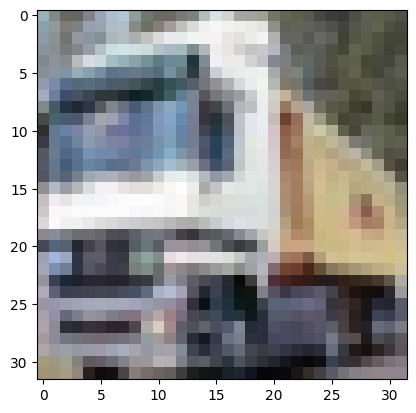

In [ ]:
from matplotlib import pyplot as plt
print(len(cifar10_train))     # training dataset 개수 확인

first_data = cifar10_train[1]
print(first_data[0].shape)  # 두번째 data의 형상 확인
print(first_data[1])        # 두번째 data의 정답 확인


plt.imshow(first_data[0].permute(1, 2, 0))
plt.show()

## VGG Net 모델 정의

In [ ]:
class VGG (nn.Module):
  def __init__ (self):
    super(VGG, self).__init__()

    self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)    # Convolution: [3x3x3] x 16, s1, p1
    self.conv1_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)   # Convolution: [3x3x16] x 32, s1, p1

    self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)   # Convolution: [3x3x32] x 32, s1, p1
    self.conv2_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)   # Convolution: [3x3x64] x 64, s1, p1

    self.conv3_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # Convolution: [3x3x64] x 128, s1, p1
    self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1) # Convolution: [3x3x128] x 256, s1, p1

    self.fc1 = nn.Linear(4096, 512)   # Fully connected layer: 4096 x 512
    self.fc2 = nn.Linear(512, 256)    # Fully connected layer: 512 x 256
    self.fc3 = nn.Linear(256, 10)     # Fully connected layer: 256 x 10

    # 파라미터를 가지지 않은 layer는 한 번만 선언해도 문제 없음
    self.relu = nn.ReLU()
    self.avgPool2d = nn.AvgPool2d(kernel_size=2, stride=2)


  def forward(self, x):

    # convolution layers
    out = self.relu(self.conv1_1(x))
    out = self.relu(self.conv1_2(out))
    out = self.avgPool2d(out)

    out = self.relu(self.conv2_1(out))
    out = self.relu(self.conv2_2(out))
    out = self.avgPool2d(out)

    out = self.relu(self.conv3_1(out))
    out = self.relu(self.conv3_2(out))
    out = self.avgPool2d(out)

    # 평탄화
    out = out.reshape(-1, 4096)

    # fully connected layers
    out = self.relu(self.fc1(out))
    out = self.relu(self.fc2(out))
    out = self.fc3(out)

    return out

## Hyper-parameters 지정

In [ ]:

batch_size = 100
learning_rate = 0.1
training_epochs = 20
loss_function = nn.CrossEntropyLoss()
network = VGG()
optimizer = torch.optim.SGD(network.parameters(), lr = learning_rate)
data_loader = DataLoader(dataset=cifar10_train,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

## 학습을 위한 반복문 선언

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda:0'

network = network.to(device)
for epoch in range(training_epochs):
  avg_cost = 0
  total_batch = len(data_loader)

  for img, label in data_loader:

    img = img.to(device)
    label = label.to(device)

    pred = network(img)

    loss = loss_function(pred, label)
    optimizer.zero_grad() # gradient 초기화
    loss.backward()
    optimizer.step()

    avg_cost += loss / total_batch

  print('Epoch: %d Loss = %f'%(epoch+1, avg_cost))

print('Learning finished')

/tmp/ipython-input-1730609884.py:24: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  print('Epoch: %d Loss = %f'%(epoch+1, avg_cost))


Epoch: 1 Loss = 2.302973
Epoch: 2 Loss = 2.302765
Epoch: 3 Loss = 2.291579
Epoch: 4 Loss = 2.303059
Epoch: 5 Loss = 2.302958
Epoch: 6 Loss = 2.282456
Epoch: 7 Loss = 2.054112
Epoch: 8 Loss = 1.853630
Epoch: 9 Loss = 1.738861
Epoch: 10 Loss = 1.625721
Epoch: 11 Loss = 1.439021
Epoch: 12 Loss = 1.302568
Epoch: 13 Loss = 1.189429
Epoch: 14 Loss = 1.088422
Epoch: 15 Loss = 0.983315
Epoch: 16 Loss = 0.876823
Epoch: 17 Loss = 0.762764
Epoch: 18 Loss = 0.647175
Epoch: 19 Loss = 0.523265
Epoch: 20 Loss = 0.422677
Learning finished


## 학습이 완료된 모델을 이용해 정답률 확인

In [ ]:
network = network.to('cpu')
with torch.no_grad(): # test에서는 기울기 계산 제외

  img_test = torch.tensor(np.transpose(cifar10_test.data, (0, 3, 1, 2)))/255.
  label_test = torch.tensor(cifar10_test.targets)

  prediction = network(img_test) # 전체 test data를 한번에 계산

  correct_prediction = torch.argmax(prediction, 1) == label_test
  accuracy = correct_prediction.float().mean()
  print('Accuracy:', accuracy.item())

Accuracy: 0.5997999906539917


## -----------------------------------------------------------------

## Model architecture 구성 실습 (ResNet)

## 모델 정의

In [ ]:
class VGG_SKIP (nn.Module):
  def __init__ (self):
    super(VGG_SKIP, self).__init__()

    self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)    # Convolution: [3x3x3] x 16, s1, p1
    self.conv1_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)   # Convolution: [3x3x16] x 32, s1, p1

    self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)   # Convolution: [3x3x32] x 32, s1, p1
    self.conv2_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)   # Convolution: [3x3x64] x 64, s1, p1

    self.conv3_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # Convolution: [3x3x64] x 128, s1, p1
    self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1) # Convolution: [3x3x128] x 256, s1, p1

    # Skip connection을 위한 convolution layer
    self.conv_skip1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.conv_skip2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.conv_skip3 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=1)

    self.fc1 = nn.Linear(4096, 512)   # Fully connected layer: 4096 x 512
    self.fc2 = nn.Linear(512, 256)    # Fully connected layer: 512 x 256
    self.fc3 = nn.Linear(256, 10)     # Fully connected layer: 256 x 10

    # 파라미터를 가지지 않은 layer는 한 번만 선언해도 문제 없음
    self.relu = nn.ReLU()
    self.avgPool2d = nn.AvgPool2d(kernel_size=2, stride=2)


  def forward(self, x):
    # convolution layers
    # Skip 입력을 위한 input 저장
    input_feature = x
    out = self.relu(self.conv1_1(x))
    out = self.relu(self.conv1_2(out))

    # Skip 입력을 위한 convolution layer 적용
    input_skip =self.relu(self.conv_skip1(input_feature))
    # Skip connection 적용
    out =torch.add(out, input_skip)
    out1 = self.avgPool2d(out)

    # Skip 입력을 위한 input 저장
    input_feature = out1

    out = self.relu(self.conv2_1(out1))
    out = self.relu(self.conv2_2(out))

    # Skip 입력을 위한 convolution layer 적용
    input_skip =self.relu(self.conv_skip2(input_feature))
    # Skip connection 적용
    out =torch.add(out, input_skip)

    out2 = self.avgPool2d(out)

    # Skip 입력을 위한 input 저장
    input_feature = out2

    out = self.relu(self.conv3_1(out2))
    out = self.relu(self.conv3_2(out))

    # Skip 입력을 위한 convolution layer 적용
    input_skip =self.relu(self.conv_skip3(input_feature))
    # Skip connection 적용
    out =torch.add(out, input_skip)

    out = self.avgPool2d(out)

    # 평탄화
    out = out.reshape(-1, 4096)

    # fully connected layers
    out = self.relu(self.fc1(out))
    out = self.relu(self.fc2(out))
    out = self.fc3(out)

    return out

## Training

In [ ]:
# Hyper-parameters 지정
batch_size = 100
learning_rate = 0.1
training_epochs = 20
loss_function = nn.CrossEntropyLoss()
network = VGG_SKIP()
optimizer = torch.optim.SGD(network.parameters(), lr = learning_rate)
data_loader = DataLoader(dataset=cifar10_train,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

# 학습을 위한 반복문 진행
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda:0'

network = network.to(device)
for epoch in range(training_epochs):
  avg_cost = 0
  total_batch = len(data_loader)

  for img, label in data_loader:

    img = img.to(device)
    label = label.to(device)

    pred = network(img)

    loss = loss_function(pred, label)
    optimizer.zero_grad() # gradient 초기화
    loss.backward()
    optimizer.step()

    avg_cost += loss / total_batch

  print('Epoch: %d Loss = %f'%(epoch+1, avg_cost))

print('Learning finished')

# 정답률 확인
network = network.to('cpu')
with torch.no_grad(): # test에서는 기울기 계산 제외

  img_test = torch.tensor(np.transpose(cifar10_test.data, (0, 3, 1, 2)))/255.
  label_test = torch.tensor(cifar10_test.targets)

  prediction = network(img_test) # 전체 test data를 한번에 계산

  correct_prediction = torch.argmax(prediction, 1) == label_test
  accuracy = correct_prediction.float().mean()
  print('Accuracy:', accuracy.item())

## -----------------------------------------------------------------

## Model architecture 구성 실습 (DenseNet)

## 모델 정의

In [ ]:
class VGG_DENSE(nn.Module):
  def __init__ (self):
    super(VGG_DENSE, self).__init__()

    self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)    # Convolution: [3x3x3] x 16, s1, p1
    self.conv1_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)   # Convolution: [3x3x16] x 32, s1, p1

    self.conv2_1 = nn.Conv2d(in_channels=35, out_channels=32, kernel_size=3, padding=1)# Convolution: [3x3x35] x 32, s1, p1
    self.conv2_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)   # Convolution: [3x3x64] x 64, s1, p1

    self.conv3_1 = nn.Conv2d(in_channels=99, out_channels=128, kernel_size=3, padding=1)# Convolution: [3x3x99] x 128, s1, p1
    self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1) # Convolution: [3x3x128] x 256, s1, p1

    self.fc1 = nn.Linear(4096, 512)   # Fully connected layer: 4096 x 512
    self.fc2 = nn.Linear(512, 256)    # Fully connected layer: 512 x 256
    self.fc3 = nn.Linear(256, 10)     # Fully connected layer: 256 x 10

    # 파라미터를 가지지 않은 layer는 한 번만 선언해도 문제 없음
    self.relu = nn.ReLU()
    self.avgPool2d = nn.AvgPool2d(kernel_size=2, stride=2)


  def forward(self, x):

    # convolution layers
    out = self.relu(self.conv1_1(x))
    out1 = self.relu(self.conv1_2(out))

    # Dense connection 적용
    out1 = torch.cat([x,out1], dim=1)

    out1 = self.avgPool2d(out1)

    out = self.relu(self.conv2_1(out1))
    out2 = self.relu(self.conv2_2(out))

    # Dense connection 적용
    out2 = torch.cat([out1, out2], dim=1)

    out2 = self.avgPool2d(out2)

    out = self.relu(self.conv3_1(out2))
    out = self.relu(self.conv3_2(out))
    out = self.avgPool2d(out)

    # 평탄화
    out = out.reshape(-1, 4096)

    # fully connected layers
    out = self.relu(self.fc1(out))
    out = self.relu(self.fc2(out))
    out = self.fc3(out)

    return out

## Training

In [ ]:
# Hyper-parameters 지정
batch_size = 100
learning_rate = 0.1
training_epochs = 20
loss_function = nn.CrossEntropyLoss()
network = VGG_DENSE()
optimizer = torch.optim.SGD(network.parameters(), lr = learning_rate)
data_loader = DataLoader(dataset=cifar10_train,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

# 학습을 위한 반복문 진행
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda:0'

network = network.to(device)
for epoch in range(training_epochs):
  avg_cost = 0
  total_batch = len(data_loader)

  for img, label in data_loader:

    img = img.to(device)
    label = label.to(device)

    pred = network(img)

    loss = loss_function(pred, label)
    optimizer.zero_grad() # gradient 초기화
    loss.backward()
    optimizer.step()

    avg_cost += loss / total_batch

  print('Epoch: %d Loss = %f'%(epoch+1, avg_cost))

print('Learning finished')

# 정답률 확인
network = network.to('cpu')
with torch.no_grad(): # test에서는 기울기 계산 제외

  img_test = torch.tensor(np.transpose(cifar10_test.data, (0, 3, 1, 2)))/255.
  label_test = torch.tensor(cifar10_test.targets)

  prediction = network(img_test) # 전체 test data를 한번에 계산

  correct_prediction = torch.argmax(prediction, 1) == label_test
  accuracy = correct_prediction.float().mean()
  print('Accuracy:', accuracy.item())

## -----------------------------------------------------------------

## Model architecture 구성 실습 (SENet)

## 모델 정의

In [ ]:
class VGG_CA (nn.Module):
  def __init__ (self):
    super(VGG_CA, self).__init__()

    self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)    # Convolution: [3x3x3] x 16, s1, p1
    self.conv1_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)   # Convolution: [3x3x16] x 32, s1, p1

    self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)   # Convolution: [3x3x32] x 32, s1, p1
    self.conv2_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)   # Convolution: [3x3x64] x 64, s1, p1

    self.conv3_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # Convolution: [3x3x64] x 128, s1, p1
    self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1) # Convolution: [3x3x128] x 256, s1, p1

    self.fc1 = nn.Linear(4096, 512)   # Fully connected layer: 4096 x 512
    self.fc2 = nn.Linear(512, 256)    # Fully connected layer: 512 x 256
    self.fc3 = nn.Linear(256, 10)     # Fully connected layer: 256 x 10

    # Channel Attention parameters
    self.adaptiveAvgPool2d = nn.AdaptiveAvgPool2d((1,1))
    self.caconv1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1)
    self.caconv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1)
    self.sigmoid = nn.Sigmoid()

    # 파라미터를 가지지 않은 layer는 한 번만 선언해도 문제 없음
    self.relu = nn.ReLU()
    self.avgPool2d = nn.AvgPool2d(kernel_size=2, stride=2)


  def forward(self, x):

    # convolution layers
    out = self.relu(self.conv1_1(x))
    out = self.relu(self.conv1_2(out))
    out = self.avgPool2d(out)

    out = self.relu(self.conv2_1(out))
    out_CA = self.relu(self.conv2_2(out))

    # Channal attention 적용
    out = self.adaptiveAvgPool2d(out_CA)
    out = self.relu(self.caconv1(out))
    out = self.sigmoid(self.caconv2(out))
    out = out*out_CA

    out = self.avgPool2d(out)

    out = self.relu(self.conv3_1(out))
    out = self.relu(self.conv3_2(out))
    out = self.avgPool2d(out)

    # 평탄화
    out = out.reshape(-1, 4096)

    # fully connected layers
    out = self.relu(self.fc1(out))
    out = self.relu(self.fc2(out))
    out = self.fc3(out)

    return out

## Training

In [ ]:
# Hyper-parameters 지정
batch_size = 100
learning_rate = 0.1
training_epochs = 20
loss_function = nn.CrossEntropyLoss()
network = VGG_CA()
optimizer = torch.optim.SGD(network.parameters(), lr = learning_rate)
data_loader = DataLoader(dataset=cifar10_train,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

# 학습을 위한 반복문 진행
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda:0'

network = network.to(device)
for epoch in range(training_epochs):
  avg_cost = 0
  total_batch = len(data_loader)

  for img, label in data_loader:

    img = img.to(device)
    label = label.to(device)

    pred = network(img)

    loss = loss_function(pred, label)
    optimizer.zero_grad() # gradient 초기화
    loss.backward()
    optimizer.step()

    avg_cost += loss / total_batch

  print('Epoch: %d Loss = %f'%(epoch+1, avg_cost))

print('Learning finished')

# 정답률 확인
network = network.to('cpu')
with torch.no_grad(): # test에서는 기울기 계산 제외

  img_test = torch.tensor(np.transpose(cifar10_test.data, (0, 3, 1, 2)))/255.
  label_test = torch.tensor(cifar10_test.targets)

  prediction = network(img_test) # 전체 test data를 한번에 계산

  correct_prediction = torch.argmax(prediction, 1) == label_test
  accuracy = correct_prediction.float().mean()
  print('Accuracy:', accuracy.item())